This notebook was made to compare surface currents in Fraser River plume during ebb tides with different river treatments

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import glob
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests

In [2]:
%matplotlib inline

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    'VENUS': {
        'East': {
            'lat': 49.0419,
            'lon': -123.3176,
            'depth': 170},
        'Central': {
            'lat': 49.0401,
            'lon': -123.4261,
            'depth': 300}
        }
    }

# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '22', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '20'}

In [4]:
def ebb_tide_time(grid_T, stn_name, PST , MSL = 0):
    "Determine ebb tide start time and end time in PST or UTC at\
    a given day at stations we got our tidal preditions"
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)
    ttide = figures.get_tides(stn_name)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    for i in np.arange(len(ttide)):
        
        if (ttide.time[i].year == t_orig.year) & (ttide.time[i].month == t_orig.month)\
        & (ttide.time[i].day == t_orig.day):
            if (ssh[i] - ssh[i-1] >0) & (ssh[i] - ssh[i+1] >0):
                ebb_tide_start = ttide.time[i].hour
            
            if (ssh[i] - ssh[i-1] <0) & (ssh[i] - ssh[i+1] <0): 
                ebb_tide_end = ttide.time[i].hour
    if PST ==0:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " UTC time"
    else:
        print "ebb tide begins at " + str(ebb_tide_start) +  ", ends at "\
        + str(ebb_tide_end) + " PST time"
    return ebb_tide_start, ebb_tide_end  

In [5]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [6]:
run_date = datetime.datetime(2015,6,15)
# previous results dataset location
results_home_pre = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir_pre = os.path.join(results_home_pre, run_date.strftime('%d%b%y').lower())

In [7]:
run_date = datetime.datetime(2015,6,15)
# new results dataset location
results_home_now = '/ocean/jieliu/research/meopar/river-treatment/'
results_dir_now = os.path.join(results_home_now, run_date.strftime('%d%b%y').lower())

In [8]:
from glob import glob

In [9]:
grid_T_pre = results_dataset('1h', 'grid_T', results_dir_pre)
grid_T_now = results_dataset('1h', 'grid_T', results_dir_now)

In [10]:
start_pre, end_pre = ebb_tide_time(grid_T_pre, 'Point Atkinson', PST = 0, MSL = 0)
start_now, end_now = ebb_tide_time(grid_T_now, 'Point Atkinson', PST = 0, MSL = 0)

ebb tide begins at 11, ends at 19 UTC time
ebb tide begins at 11, ends at 19 UTC time


# set up function to automatic make currents_salinity figures

In [11]:
start_time = datetime.datetime(2015,6,15, start_pre)
end_time = datetime.datetime(2014,6,15, end_pre)

numhours = (end_time - start_time).seconds // 3600
hours = [start_time + datetime.timedelta(hours=num)
             for num in range(0, numhours+1)]

In [12]:
def quiver_salinity(t, ax):
    #ax.clear()

    mesh=ax.contourf(lon,lat,Ss[t],cs,cmap=cmap,extend='both')
    #land
    viz_tools.plot_land_mask(ax,bathy,coords='map',xslice=x,yslice=y,color='burlywood')
    #quivers
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st], Us[t,::st,::st], Vs[t,::st,::st],
                       pivot='mid', width=0.003,scale=25, color='white',
                       headwidth=2,headlength=2)
    ax.quiverkey(quiver,-122.8,49.1, 1, '1 m/s',
                 coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '20'})
    
    #title
    timestamp = time[t]
        
    ax.set_title(timestamp.strftime('%d-%b-%Y %H:%M'), **title_font)
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_xlabel('Longitude', **axis_font)
    ax.set_ylabel('Latitude', **axis_font)
        
    
    return mesh

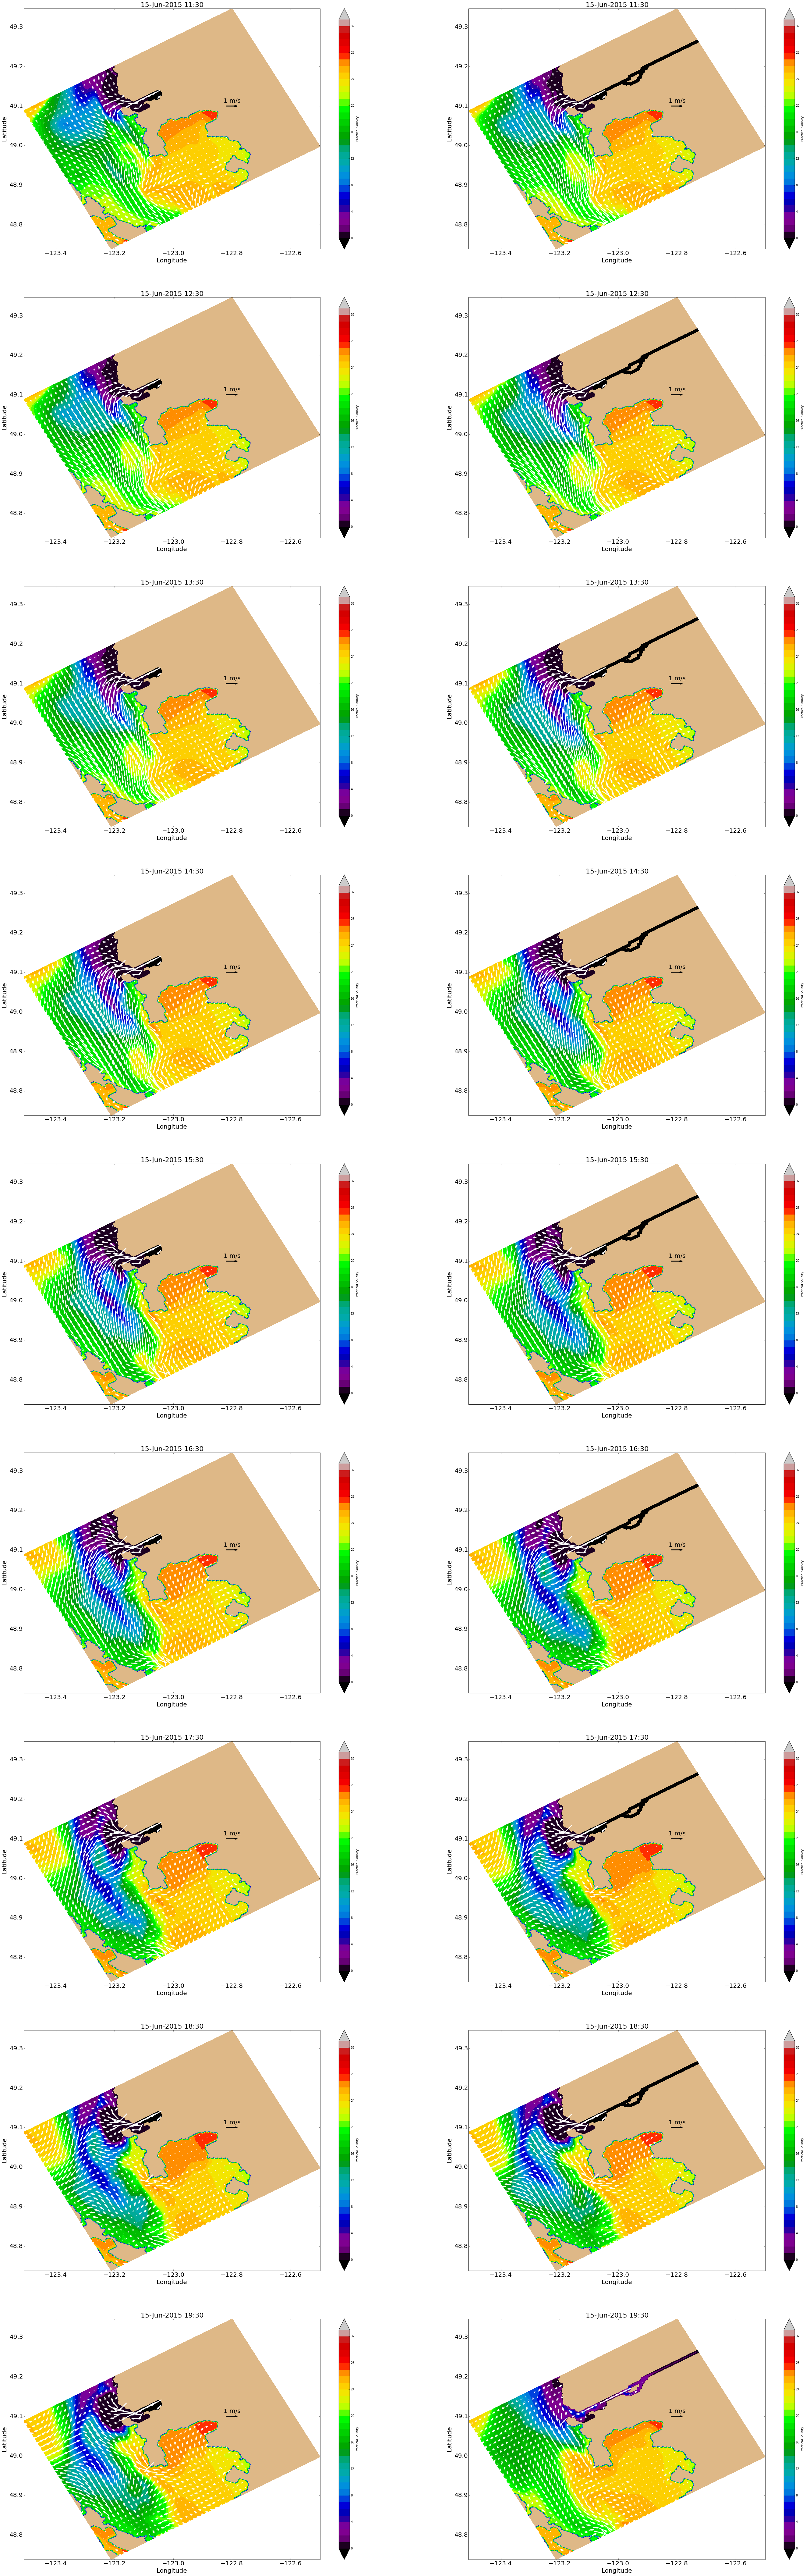

In [13]:
#subset
ist=260
ien=398
jst=350
jen=440
depth=0
x=np.arange(ist,ien)
y=np.arange(jst,jen)
smin, smax, dels = 0, 34, 1
cs = np.arange(smin,smax)
cmap = plt.get_cmap('spectral')
st=3

#initalize arrays
Us=np.zeros((1, y.shape[0],x.shape[0])); 
Vs=np.zeros((1, y.shape[0],x.shape[0]))
Ss=np.zeros((1, y.shape[0],x.shape[0]))
time=np.array([])


## set up figure frame
fig, axs = plt.subplots((len(hours)), 2, figsize=(48, 150))

#loop through files
results_home_pre = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_home_now = '/ocean/jieliu/research/meopar/river-treatment/'
results_home = {results_home_pre: 0, \
               results_home_now: 1}
for i in results_home.keys():
       
    
    results_dir = os.path.join(i, run_date.strftime('%d%b%y').lower())
    grid_U = results_dataset('1h','grid_U',results_dir)
    grid_V = results_dataset('1h','grid_V',results_dir)
    grid_T = results_dataset('1h','grid_T',results_dir)
    
    #load variables
    U = grid_U.variables['vozocrtx'][hours[0].hour: hours[len(hours) -1 ].hour + 1, 0,jst-1:jen,ist-1:ien]
    V = grid_V.variables['vomecrty'][hours[0].hour: hours[len(hours) -1].hour + 1, 0,jst-1:jen,ist-1:ien]
    S = grid_T.variables['vosaline'][hours[0].hour: hours[len(hours) -1].hour + 1, 0,jst:jen,ist:ien]

    #masking
    U = np.ma.masked_values(U,0)
    V = np.ma.masked_values(V,0)

    #unstagger
    u,v = viz_tools.unstagger(U,V)
    #rotate
    theta = np.pi*29/180
    uE = u*np.cos(theta) - v*np.sin(theta)
    vN = u*np.sin(theta) +v*np.cos(theta)
    #append
    Us = np.append(Us,uE,axis=0)
    Vs = np.append(Vs,vN,axis=0)
    Ss = np.append(Ss,S,axis=0)

    t = nc_tools.timestamp(grid_T, np.arange(len(hours)+ hours[0].hour))
    for ind in range(len(t)):
        t[ind] = t[ind].datetime
    time = np.append(time, t[hours[0].hour :]) 
    
    ##masking them
    Us=Us[1:,:,:]; Us=np.ma.masked_values(Us,0)
    Vs=Vs[1:,:,:]; Vs=np.ma.masked_values(Vs,0)
    Ss=Ss[1:,:,:];
    

    if  results_home[i] ==0:
        bathy = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc') 
        #lats and lons
        lat = bathy.variables['nav_lat'][jst:jen,ist:ien]
        lon = bathy.variables['nav_lon'][jst:jen,ist:ien]
        for i in range(len(hours)):
            ax = axs[i , 0]

            mesh = quiver_salinity(i, ax) ## plot quiver and salinity in different time
            cbar = plt.colorbar(mesh, ax=ax)
            cbar.set_label('Practical Salinity')
    elif results_home[i] ==1:
        bathy = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea3.nc')
        #lats and lons
        lat = bathy.variables['nav_lat'][jst:jen,ist:ien]
        lon = bathy.variables['nav_lon'][jst:jen,ist:ien]
        for i in range(len(hours)):
            ax = axs[i , 1]

            mesh = quiver_salinity(i, ax) ## plot quiver and salinity in different time
            cbar = plt.colorbar(mesh, ax=ax)
            cbar.set_label('Practical Salinity')
            #cbar.ax.set_xticklabels(color = 'black', fontsize = '18')
            